# Evaluate features

This notebook demonstrate how to evaluate the features stored in the anndata.obsm.
The task we are interested in is to predict the gene expression based on the cell_type label and the covariates. 

We evaluate different metric to show that the semantic features obtained from the self supervised learning (ssl) frameworks are biological relevant.

In [1]:
# TO REMOVE when notebook is stable

%load_ext autoreload
%autoreload 2

### Common Imports

In [2]:
import numpy
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad

# tissue_purifier import
import tissue_purifier as tp

### Download the annotated anndata object 

Altenatively you can use the anndata files generated by running notebook2_all.

In [3]:
import tissue_purifier.io

bucket_name = "ld-data-bucket"
annotated_anndata_source_path = "tissue-purifier/annotated_slideseq_testis_anndata_h5ad.tar.gz"
annotated_anndata_dest_path = "./annotated_slideseq_testis_anndata_h5ad.tar.gz"
annotated_anndata_dest_folder = "./testis_anndata_annotated"

#tp.io.download_from_bucket(bucket_name, annotated_anndata_source_path, annotated_anndata_dest_path)   
#with tarfile.open(annotated_anndata_dest_path, "r:gz") as fp:
#    fp.extractall(path=annotated_anndata_dest_folder)
    
# Make a list of all the h5ad files in the annotated_anndata_dest_folder
fname_list = []
for f in os.listdir(annotated_anndata_dest_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

['anndata_sick3.h5ad', 'anndata_sick1.h5ad', 'anndata_sick2.h5ad', 'anndata_wt2.h5ad', 'anndata_wt1.h5ad', 'anndata_wt3.h5ad']


### Decide how to filter the anndata object

In [4]:
# filter cells parameters
fc_bc_min_umi = 200                  # filter cells with too few UMI
fc_bc_max_umi = 3000                 # filter cells with too many UMI
fc_bc_min_n_genes_by_counts = 10     # filter cells with too few GENES
fc_bc_max_n_genes_by_counts = 2500   # filter cells with too many GENES
fc_bc_max_pct_counts_mt = 5          # filter cells with mitocrondial fraction too high

# filter genes parameters
fg_bc_min_cells_by_counts = 1000      # filter genes which appear in too few CELLS

# filter rare cell types parameters
fctype_bc_min_cells_absolute = 100   # filter cell-types which are too RARE in absolute number
fctype_bc_min_cells_frequency = 0.01 # filter cell-types which are too RARE in relative abundance

### Open the first annotated anndata 

In [5]:
adata = read_h5ad(filename=os.path.join(annotated_anndata_dest_folder, fname_list[0]))
adata

AnnData object with n_obs × n_vars = 33441 × 23514
    obs: 'x', 'y', 'cell_type'
    obsm: 'barlow', 'dino', 'ncv_k10', 'ncv_k100', 'ncv_k20', 'ncv_k200', 'ncv_k50', 'ncv_k500', 'simclr', 'vae'

### compute few metrics

In [6]:
import scanpy as sc
cell_type_key = "cell_type"

# mitocondria metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# counts cells frequency
tmp = adata.obs[cell_type_key].values.describe()
print(tmp)
mask1 = (tmp["counts"] > fctype_bc_min_cells_absolute)
mask2 = (tmp["freqs"] > fctype_bc_min_cells_frequency)
mask = mask1 * mask2
cell_type_keep = set(tmp[mask].index.values)
adata.obs["keep_ctype"] = adata.obs["cell_type"].apply(lambda x: x in cell_type_keep)

# Note that adata has extra annotation now
adata

             counts     freqs
categories                   
ES            12552  0.375348
Endothelial     417  0.012470
Leydig          340  0.010167
Macrophage      623  0.018630
Myoid           969  0.028976
RS             6780  0.202745
SPC            8069  0.241291
SPG            2238  0.066924
Sertoli        1453  0.043450


AnnData object with n_obs × n_vars = 33441 × 23514
    obs: 'x', 'y', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'keep_ctype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'barlow', 'dino', 'ncv_k10', 'ncv_k100', 'ncv_k20', 'ncv_k200', 'ncv_k50', 'ncv_k500', 'simclr', 'vae'

### Filter out cells, genes and cell-type

In [7]:
adata = adata[adata.obs["total_counts"] > fc_bc_min_umi, :] 
adata = adata[adata.obs["total_counts"] < fc_bc_max_umi, :] 
adata = adata[adata.obs["n_genes_by_counts"] > fc_bc_min_n_genes_by_counts, :] 
adata = adata[adata.obs["n_genes_by_counts"] < fc_bc_max_n_genes_by_counts, :] 
adata = adata[adata.obs["pct_counts_mt"] < fc_bc_max_pct_counts_mt, :]
adata = adata[adata.obs["keep_ctype"] == True, :]
adata = adata[:, adata.var["n_cells_by_counts"] > fg_bc_min_cells_by_counts]

### Show the cell-type count after filtering

In [8]:
tmp = adata.obs[cell_type_key].values.describe()
print(tmp)
adata

             counts     freqs
categories                   
ES            10089  0.388786
Endothelial     253  0.009750
Leydig          169  0.006513
Macrophage      468  0.018035
Myoid           516  0.019884
RS             5767  0.222235
SPC            6231  0.240116
SPG            1533  0.059075
Sertoli         924  0.035607


View of AnnData object with n_obs × n_vars = 25950 × 4034
    obs: 'x', 'y', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'keep_ctype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'barlow', 'dino', 'ncv_k10', 'ncv_k100', 'ncv_k20', 'ncv_k200', 'ncv_k50', 'ncv_k500', 'simclr', 'vae'

### Make a gene dataset from the anndata 

In [9]:
from tissue_purifier.genex import *

covariate_key = "ncv_k10"

gene_dataset = make_gene_dataset_from_anndata(
        anndata=adata,
        cell_type_key='cell_type',
        covariate_key=covariate_key,
        preprocess_strategy='raw',
        apply_pca=False)

In [10]:
gene_dataset.describe()

covariates           ---> torch.Size([25950, 9])
cell_type_ids        ---> torch.Size([25950])
counts               ---> torch.Size([25950, 4034])
k_cell_types         ---> 9
cell_type_mapping    ---> {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}
gene_names           ---> list of length 4034


### Split the dataset into train/test/val

In [11]:
train_dataset, test_dataset, val_dataset = next(iter(train_test_val_split(gene_dataset, random_state=0)))

In [12]:
print("---------")
train_dataset.describe()
print("---------")
test_dataset.describe()
print("---------")
val_dataset.describe()

---------
covariates           ---> torch.Size([20760, 9])
cell_type_ids        ---> torch.Size([20760])
counts               ---> torch.Size([20760, 4034])
k_cell_types         ---> 9
cell_type_mapping    ---> {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}
gene_names           ---> list of length 4034
---------
covariates           ---> torch.Size([3893, 9])
cell_type_ids        ---> torch.Size([3893])
counts               ---> torch.Size([3893, 4034])
k_cell_types         ---> 9
cell_type_mapping    ---> {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}
gene_names           ---> list of length 4034
---------
covariates           ---> torch.Size([1297, 9])
cell_type_ids        ---> torch.Size([1297])
counts               ---> torch.Size([1297, 4034])
k_cell_types         ---> 9
cell_type_mapping    ---> {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 

### Note that the split is tratified by cell_types

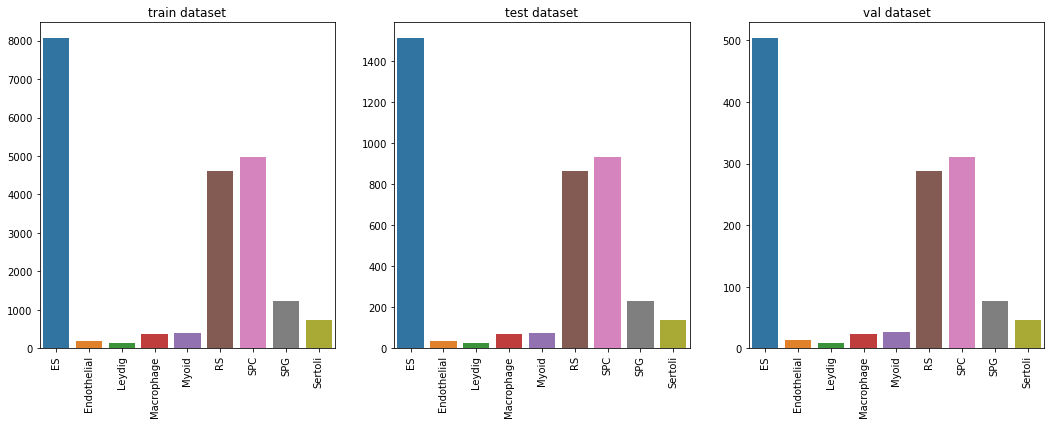

In [13]:
ncols=3
fig, axes = plt.subplots(ncols=ncols, figsize=(6*ncols,6))

for c, (dataset, title) in enumerate(zip([train_dataset, test_dataset, val_dataset], ["train dataset", "test dataset", "val dataset"])):
    x = list(dataset.cell_type_mapping.keys())
    y = torch.bincount(dataset.cell_type_ids).numpy()
    _ = seaborn.barplot(x=x, y=y, ax=axes[c])
    x_labels_raw = axes[c].get_xticklabels()
    axes[c].set_xticklabels(labels=x_labels_raw, rotation=90)
    _ = axes[c].set_title(title)

### Example training the gene regression model and testing it 

In [25]:
gr = GeneRegression()
gr.configure_optimizer(optimizer_type='adam', lr=5E-3)

In [26]:
# this will take about 5 minutes on a NVIDIA T4 GPU
# adjust subsample_size_cells and subsample_size_genes to make sure:
# 1. not to run out of GPU memory
# 2. have high GPU utilization

import time
start_time = time.time()

results_test = gr.train_and_test(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    test_num_samples=10,
    train_steps=200,
    train_print_frequency=100,
    use_covariates=False,
    l1_regularization_strength=None,
    l2_regularization_strength=None,
    eps_range=(1.0E-5, 1.0E-2),
    subsample_size_cells=2000,
    subsample_size_genes=None,
    from_scratch=True)

print("training duration {} seconds".format(time.time()-start_time))

[iter 1]  loss: 67414878577.2188
[iter 100]  loss: 43326613873.2188
[iter 200]  loss: 30158174577.2188
training completed
training duration 38.83034610748291 seconds


### check the loss to see if the model has converged

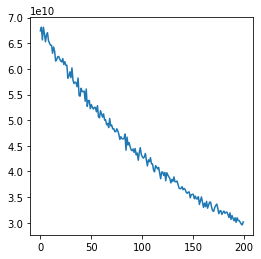

In [27]:
gr.show_loss()

### if satisfied save the checkpoint else extend the training

[iter 401]  loss: 16824457585.2188
[iter 500]  loss: 13869410673.2188
[iter 600]  loss: 10980178289.2188
[iter 700]  loss: 9138217329.2188
[iter 800]  loss: 7701774193.2188
[iter 900]  loss: 6488800625.2188
[iter 1000]  loss: 5538058609.2188
[iter 1100]  loss: 4923670385.2188
[iter 1200]  loss: 4299242865.2188
[iter 1300]  loss: 3749377905.2188
[iter 1400]  loss: 3345838961.2188
[iter 1500]  loss: 3053345137.2188
[iter 1600]  loss: 2749001073.2188
[iter 1700]  loss: 2496175985.2188
[iter 1800]  loss: 2284426865.2188
[iter 1900]  loss: 2050392945.2188
[iter 2000]  loss: 1888162161.2188
[iter 2100]  loss: 1702985841.2188
[iter 2200]  loss: 1498335345.2188
[iter 2300]  loss: 1445272433.2188
[iter 2400]  loss: 1326511729.2188
training completed


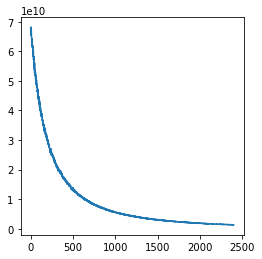

In [31]:
# Here we:
# 1. extend the training for 200 additional steps
# 2. recheck the loss function
# 3. save the ckpt
results_test = gr.extend_train_and_test(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    test_num_samples=10,
    train_steps=2000,
    train_print_frequency=100,)
            
gr.show_loss()

In [32]:
gr.save_ckpt("no_cov.pt")

### visualization

FROM HERE

loop for many l1 and l2 
no_covariate, and covariate.
make plots

### Evaluate the fit on both the train and test dataset

In [40]:
results_test = gr.predict(
    dataset=test_dataset,
    num_samples=10,
    subsample_size_cells=400,
    subsample_size_genes=None)

results_train = gr.predict(
    dataset=train_dataset,
    num_samples=10,
    subsample_size_cells=400,
    subsample_size_genes=None)

logq_train_df, q_train_df, q_data_train_df, counts_train_ng = results_train
logq_test_df, q_test_df, q_data_test_df, counts_test_ng = results_test

### find the top k highly expressed gene

In [41]:
gene_index = torch.topk(train_dataset.counts.sum(axis=0), axis=-1, k=10)[1]
gene_names = numpy.array(train_dataset.gene_names)[gene_index]
print(gene_index)
print(gene_names)

tensor([2766, 2765, 3648, 3649, 2056, 3245, 2495, 2206, 1772, 3296])
['Prm2' 'Prm1' 'Tnp1' 'Tnp2' 'Ldhc' 'Smcp' 'Odf2' 'Meig1' 'Gsg1' 'Spa17']


### plot the gene distribution

# FROM HERE

In [ ]:
assert 1==2

AttributeError: 'PathCollection' object has no property 'col'

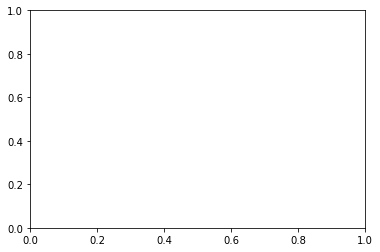

In [47]:
train_dataset.counts[:, 2766]
counts_train_ng[:, 2766]

def scatter_plots_true_pred(cell_types_n, true_counts_n, predicted_counts_n, titles, figsize, ncols):
    unique_cell_labels = numpy.unique(cell_types_n)
    
fig, axes = plt.subplots(ncols

_ = seaborn.scatterplot(x=train_dataset.counts[:, 2766], y=counts_train_ng[:, 2766], col=train_dataset.cell_type_ids)

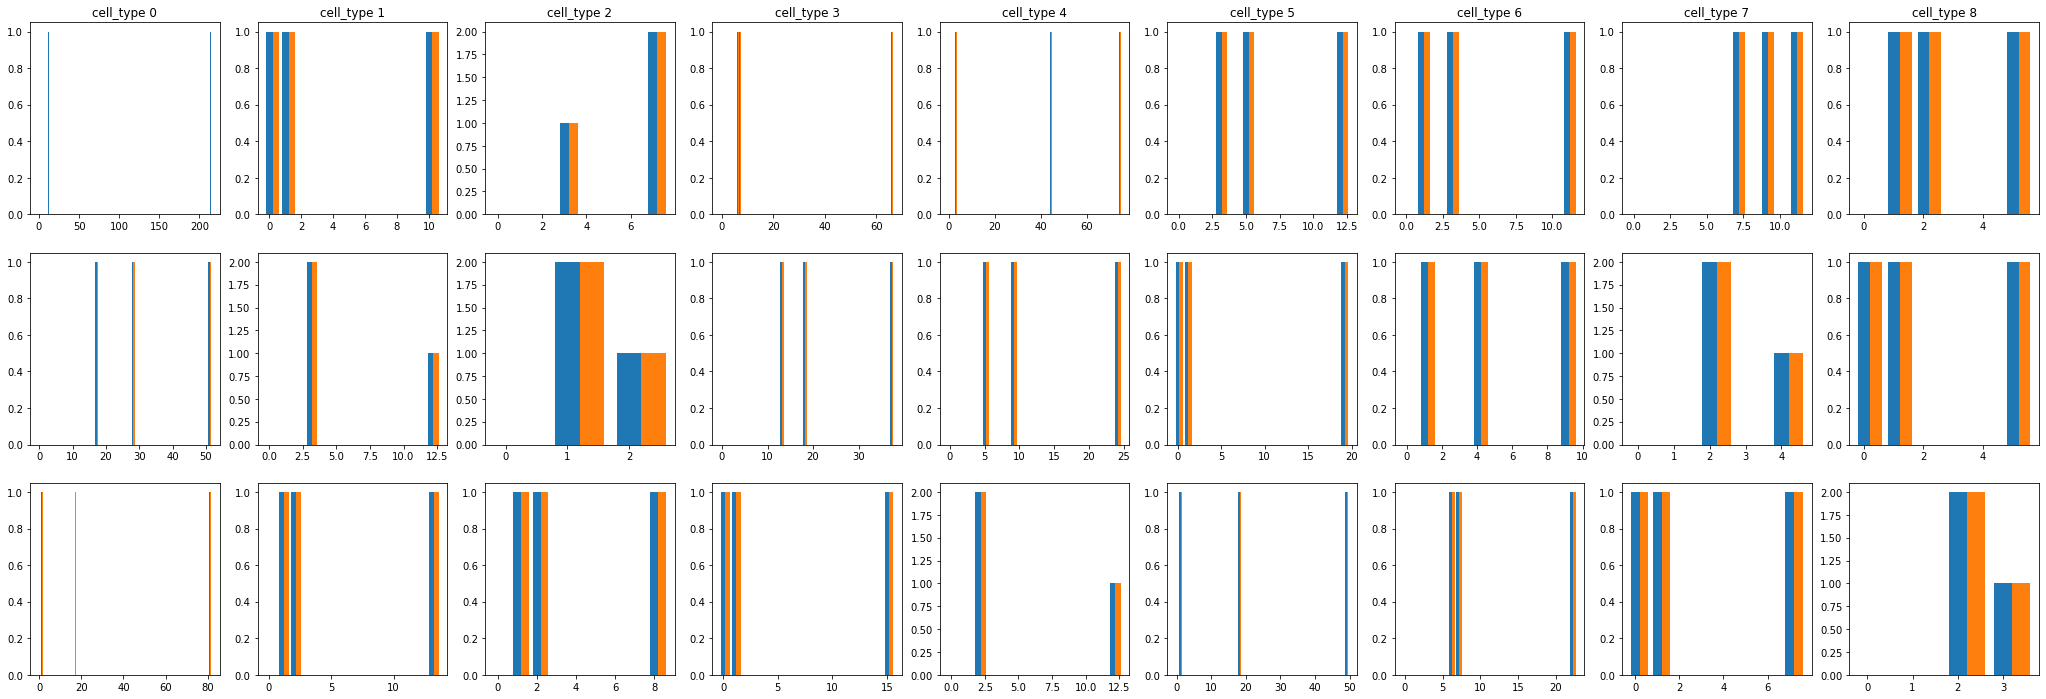

In [42]:
plot_gene_hist(train_dataset.cell_type_ids, train_dataset.counts[:, gene_index[:3]], counts_train_ng[:, gene_index[:3]], bins=20)



### Find a highly expressed gene

In [ ]:
torch.topk(train_dataset.counts.sum(axis=0), axis=-1, k=20)

In [ ]:
plot_gene_hist(train_dataset.cell_type_ids, train_dataset.counts[:, :2], counts_train_ng[:, :2], bins=20)

In [ ]:
q_train_df

In [ ]:
plt.imshow(q_test[:,:100])

In [ ]:
plt.imshow(q_train[:,:100])

In [ ]:
plt.plot(torch.mean(q_test/q_train, dim=1))

In [ ]:
plt.plot(torch.mean(q_test/q_train, dim=0))

In [ ]:
plt.imshow(q_train[:,:100])

In [ ]:
plt.imshow(q_test[:,:100])

In [ ]:
plt.imshow(q_data[:,:100])

In [ ]:
assert 1==2

In [ ]:
logq, q, q_data = results_test

In [ ]:
plt.imshow(q_data[:,:100])

In [ ]:
q_data/q

In [ ]:
plt.imshow(q[:,:100])

In [ ]:
plt.imshow(logq[:,:100])

In [ ]:
results_train = gr.predict(
    dataset=train_dataset,
    num_samples=10,
    subsample_size_cells=400,
    subsample_size_genes=400)

In [ ]:
df0, df1, df2 = result

In [ ]:
df2

### visualize the results